In [64]:
import requests
import datetime
from elasticsearch import Elasticsearch
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
def to_date(s):
    dt = datetime.datetime.utcfromtimestamp(s / 1e3)
    return dt.strftime("%Y-%m-%d")
def get_visit_list(s):
    data={}
    data['visit_list'] = s['用户ID'].tolist()
    return pd.Series(data)

In [158]:
def user_rebuy_plot(date):
    dsl = {'aggs': {'my_buckets': {'composite': {'size': 9999999,
                                       'sources': [
                                                   {'id': {'terms': {'field': 'id'}}},

                                                  ]}}},
                 'query': {'bool': {'must': [{'range': {'first_vip_created': {'format': 'yyyy-MM-dd',
                                                              'gte': date,
                                                              'lte': date,
                                                              'time_zone': '+00:00'}}}]}}}
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index='es_user_table', doc_type='user', body=dsl,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
    df1 = json_normalize(res['aggregations']['my_buckets']['buckets'])
    df1.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df1.columns))
    
    dsl11 = {
        'aggs': {'my_buckets': {'aggregations': {'打开(Visitor)': {'cardinality': {'field': 'session_id', 'precision_threshold': 100}}},
                         'composite': {'size': 9999999,
                                       'sources': [{"用户ID": {"terms": {"field": 'user_id'}}},
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=1))[:10],
                                                    'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=7))[:10],
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                            # {'terms': {'event_name': ['index', '首页']}},
                             {'terms': {'user_id': df1['id'].tolist()}},
                            # {'terms': {'event_type': ['event']}}
                        ]}}}
    es11 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res11 = es11.search(index='shop_pv_event', doc_type='pv_event', body=dsl11,
                    _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                    search_type='query_then_fetch')
    df11 = json_normalize(res11['aggregations']['my_buckets']['buckets'])
    df11.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df11.columns))
                                                      
    active_list = []
    for i in range(len(df11)):
        if df11.iloc[i]['打开(Visitor).value']>=3:     
            active_list.append(df11.iloc[i]['用户ID'])
        
    dead_list = list(set(df1['id'].tolist())-set(active_list))
    
    return dead_list

def get_order_list(s):
    data={}
    data['order_list'] = s['用户ID'].tolist()
    return pd.Series(data)

In [159]:
def order_number_curve(date):
    dead_list = user_rebuy_plot(date)
    dsl_list = {
                'query': {'bool': {'must': [
                                            {'terms': {'user_id': dead_list}},
                                            {'terms': {'order_status': ['confirmed',
                                                                        'done',
                                                                        'fulfilled']}},
                                            {'range': {'paytime': {'format': 'yyyy-MM-dd',
                                                              'gte': date,
                                                              'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=7))[:10],
                                                              'time_zone': '+00:00'}}},
                                            ]}},
                "aggs": {
                    "my_buckets": {
                        "composite": {
                            'size': 9999999,
                            "sources": [{"用户ID": {"terms": {"field": 'user_id'}}},
                                #{"单价": {"terms": {"field": 'skutotal_price'}}}
                                ]}}}}
    es_list = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res_list = es_list.search(index='es_order_table', doc_type='order', body=dsl_list,
                            _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                            search_type='query_then_fetch')
    df_list = json_normalize(res_list['aggregations']['my_buckets']['buckets'])
    df_list.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_list.columns))
    
    df_order = df_list.groupby('doc_count').apply(get_order_list).reset_index()
    dsl_all = {
        'aggs': {'my_buckets': {'aggregations': {'打开(Visitor)': {'cardinality': {'field': 'session_id', 'precision_threshold': 100}}},
                         'composite': {'size': 9999999,
                                       'sources': [{"用户ID": {"terms": {"field": 'user_id'}}},]}}},
         'query': {'bool': {'must': [{'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=8))[:10],
                                                    'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=14))[:10],
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                        ]}}}
    es_all = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res_all = es_all.search(index='shop_pv_event', doc_type='pv_event', body=dsl_all,
                    _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                    search_type='query_then_fetch')
    df_all = json_normalize(res_all['aggregations']['my_buckets']['buckets'])
    df_all.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_all.columns))
    new_visit_list = df_all['用户ID'].tolist()
    visit_list=[int(x) for x in new_visit_list]

    per_rem = []
    for i in range(len(df_order)):
        list_together = list(set(df_order.iloc[i]['order_list']).intersection(set(visit_list)))
        per_rem.append(len(list_together)/len(df_order.iloc[i]['order_list']))

    df_order['留存率'] = per_rem  
    return plt.plot(df_order['doc_count'],df_order['留存率'])

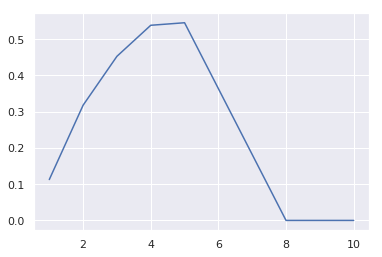

In [161]:
date='2019-05-30'
order_number_curve(date)

订单划分

In [162]:
def number_and_list(date, split_number):
    dead_list = user_rebuy_plot(date)
    dsl_list = {
                'query': {'bool': {'must': [
                                            {'terms': {'user_id': dead_list}},
                                            {'terms': {'order_status': ['confirmed',
                                                                        'done',
                                                                        'fulfilled']}},
                                            {'range': {'paytime': {'format': 'yyyy-MM-dd',
                                                              'gte': date,
                                                              'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=7))[:10],
                                                              'time_zone': '+00:00'}}},
                                            ]}},
                "aggs": {
                    "my_buckets": {
                        "composite": {
                            'size': 9999999,
                            "sources": [{"用户ID": {"terms": {"field": 'user_id'}}},
                                #{"单价": {"terms": {"field": 'skutotal_price'}}}
                                ]}}}}
    es_list = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res_list = es_list.search(index='es_order_table', doc_type='order', body=dsl_list,
                            _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                            search_type='query_then_fetch')
    df_list = json_normalize(res_list['aggregations']['my_buckets']['buckets'])
    df_list.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_list.columns))
    
    target_user_list_c=[]
    for i in range(len(df_list)):
        if df_list.iloc[i]['doc_count'] > split_number:
            target_user_list_c.append(df_list.iloc[i]['用户ID'])
        #else:
        #    continue
    
    target_user_list = list(set(dead_list)-set(target_user_list_c))
    
    return target_user_list
            
        

In [131]:
user_redpocket_list=number_and_list(date, 3)

In [132]:
def distribution_order_price(date,split_number):
    target_user_list_1 = number_and_list(date,split_number)
    dsl = {
                    'query': {'bool': {'must': [
                                                {'terms': {'user_id': [str(x) for x in target_user_list_1]}},
                                                {'terms': {'order_status': ['confirmed',
                                                                            'done',
                                                                            'fulfilled']}},

                                                ]}},
                    "aggs": {
                        "my_buckets": {
                            "composite": {
                                'size': 9999999,
                                "sources": [
                                    {"单价": {"terms": {"field": 'total_price'}}}
                                    ]}}}}
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index='es_order_table', doc_type='order', body=dsl,
                                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                search_type='query_then_fetch')
    df = json_normalize(res['aggregations']['my_buckets']['buckets'])
    df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df.columns))
    df_123=df[df['单价']<40]
    return sns.distplot(df_123['单价'])

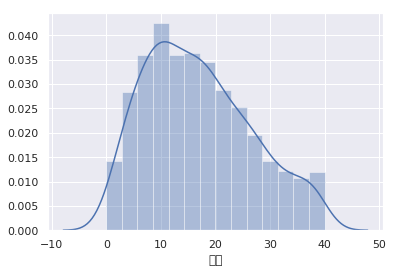

In [133]:
distribution_order_price('2019-05-25',3)

In [134]:

def dead_list_visit(date):
    dsl_active = {
            'aggs': {'my_buckets': {'aggregations': {'打开(Visitor)': {'cardinality': {'field': 'session_id', 'precision_threshold': 100}}},
                             'composite': {'size': 9999999,
                                           'sources': [#{"用户ID": {"terms": {"field": 'user_id'}}},
                                               {'日期': {'date_histogram': {'field': 'created',
                                                                                  'interval': '1d',
                                                                                  'time_zone': '+08:00'}}}
                                           ]}}},
             'query': {'bool': {'must': [{'range': {'created': {'format': 'yyyy-MM-dd',
                                                        'gte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=0))[:10],
                                                        'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=14))[:10],
                                                        'time_zone': '+08:00'}}},
                                 {'terms': {'app_name': ['vip-mini']}},
                                 {'terms': {'user_id': [str(x) for x in user_redpocket_list]}},
                            ]}}}
    es_active = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res_active = es_active.search(index='shop_pv_event', doc_type='pv_event', body=dsl_active,
                    _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                    search_type='query_then_fetch')
    df_active = json_normalize(res_active['aggregations']['my_buckets']['buckets'])
    df_active.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_active.columns))
    df_active['日期'] = df_active['日期'].apply(to_date)
    df_active['日期'] = pd.to_datetime(df_active['日期'])
    active_per = []
    for i in range(len(df_active)):
        active_per.append(df_active.iloc[i]['打开(Visitor).value']/len(user_redpocket_list))
    df_active['占比']= active_per

    
    
    return plt.plot(df_active['日期'],df_active['占比']),plt.xticks(rotation='60')

([<matplotlib.lines.Line2D at 0x7f0216913128>],
 (array([737214., 737215., 737216., 737217., 737218., 737219., 737220.,
         737221., 737222., 737223.]), <a list of 10 Text xticklabel objects>))

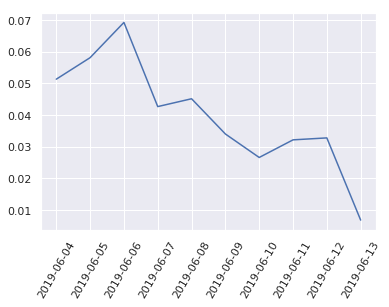

In [135]:
date = '2019-06-05'
dead_list_visit(date)

In [168]:
date = '2019-05-29'
user_red_list,date_index_list,length=[],[],[]
for i in range(8):
    date_index=str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=i))[:10]
    date_index_list.append(date_index)
    length.append(len(number_and_list(date_index, 1)))
    user_red_list.append(number_and_list(date_index, 1))

In [169]:
val = {'date_index':date_index_list,'人数':length,'user_red':user_red_list}
red_list=pd.DataFrame(val)

In [170]:
all_number,per_red=[],[]
for i in range(len(red_list)):   
    dsl = {'aggs': {'my_buckets': {'composite': {'size': 9999999,
                                           'sources': [
                                                       {'id': {'terms': {'field': 'id'}}},

                                                      ]}}},
                     'query': {'bool': {'must': [{'range': {'first_vip_created': {'format': 'yyyy-MM-dd',
                                                                  'gte': red_list.iloc[i]['date_index'],
                                                                  'lte': red_list.iloc[i]['date_index'],
                                                                  'time_zone': '+00:00'}}}]}}}
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index='es_user_table', doc_type='user', body=dsl,
                            _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                            search_type='query_then_fetch')
    df1 = json_normalize(res['aggregations']['my_buckets']['buckets'])
    df1.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df1.columns))
    all_number.append(len(df1))
    per_red.append(red_list.iloc[i]['人数']/len(df1))

In [171]:
red_list['总人数']=all_number
red_list['百分比']=per_red

In [172]:
red_list.to_csv('新不活跃会员的列表.csv')

In [41]:
target_user_list = number_and_list('2019-06-02',3)
dsl = {
                    'query': {'bool': {'must': [
                                                {'terms': {'user_id': [str(x) for x in target_user_list]}},
                                                {'terms': {'order_status': ['confirmed',
                                                                            'done',
                                                                            'fulfilled']}},

                                                ]}},
                    "aggs": {
                        "my_buckets": {
                            "composite": {
                                'size': 9999999,
                                "sources": [{'品类':{'terms':{'field':'group_category_name'}}},
                                            {"单价": {"terms": {"field": 'total_price'}}},
                                            {"id": {"terms": {"field": 'user_id'}}}
                                    ]}}}}
es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res = es.search(index='es_order_table', doc_type='order', body=dsl,
                                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                search_type='query_then_fetch')
df = json_normalize(res['aggregations']['my_buckets']['buckets'])
df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df.columns))

In [47]:
df=df[df['单价']>1]

In [48]:
def price_cate_list(s):
    data={}
    data['价格列表']=s['单价'].tolist()
    return pd.Series(data)

df_list_cate = df.groupby('品类').apply(price_cate_list).reset_index()
df_list_cate.loc[9]['价格列表']

[76.91999816894531,
 106.4800033569336,
 111.5999984741211,
 126.36000061035156,
 160.0800018310547,
 208.55999755859375]

In [49]:
def mediannum(num):
    listnum = [num[i] for i in range(len(num))]
    listnum.sort()
    lnum = len(num)
    if lnum % 2 == 1:
        i = int((lnum + 1) / 2)-1
        return listnum[i]
    else:
        i = int(lnum / 2)-1
        return (listnum[i] + listnum[i + 1]) / 2


value_mean=[]
for i in range(len(df_list_cate)):
    value_mean.append(mediannum(df_list_cate.iloc[i]['价格列表']))

In [50]:
df_list_cate['中位价格']=value_mean

In [51]:
df_list_cate

,品类,价格列表,中位价格
0,null,"[2.799999952316284, 2.799999952316284, 2.79999...",2.800000
1,下午茶,"[5.21999979019165, 6.960000038146973, 8.699999...",6.960000
2,中式烧烤/烤串,[98.5],98.500000
3,创意菜,"[10.0, 19.0]",14.500000
4,小吃,"[4.0, 7.0, 8.0, 13.0, 13.0, 13.0, 13.0, 13.0, ...",13.000000
5,川味/重庆火锅,"[209.52000427246094, 263.25, 305.17999267578125]",263.250000
6,快餐,"[2.940000057220459, 3.0, 9.0, 15.0, 26.1000003...",26.100000
7,日本料理,"[19.139999389648438, 20.8799991607666, 147.949...",147.949997
8,早餐档,"[1.9600000381469727, 2.940000057220459, 2.9900...",4.700000
9,港式/茶餐厅,"[76.91999816894531, 106.4800033569336, 111.599...",118.980000


In [103]:
date='2019-05-29'
active_list = user_rebuy_plot(date)
dsl_list = {
                'query': {'bool': {'must': [
                                            {'terms': {'user_id': active_list}},#
                                            {'terms': {'order_status': ['confirmed',
                                                                        'done',
                                                                        'fulfilled']}},
                                            {'range': {'paytime': {'format': 'yyyy-MM-dd',
                                                              'gte': date,
                                                              'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=7))[:10],
                                                              'time_zone': '+00:00'}}},
                                            ]}},
                "aggs": {
                    "my_buckets": {
                        "composite": {
                            'size': 9999999,
                            "sources": [{"用户ID": {"terms": {"field": 'user_id'}}},
                                #{"单价": {"terms": {"field": 'skutotal_price'}}}
                                ]}}}}
es_list = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_list = es_list.search(index='es_order_table', doc_type='order', body=dsl_list,
                            _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                            search_type='query_then_fetch')
df_list = json_normalize(res_list['aggregations']['my_buckets']['buckets'])
df_list.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_list.columns))

target_user_list_c=[]
for i in range(len(df_list)):
    if df_list.iloc[i]['doc_count'] > 3:
        target_user_list_c.append(df_list.iloc[i]['用户ID'])

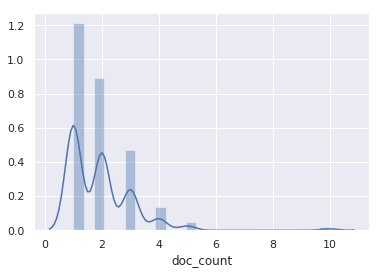

In [79]:
sns.distplot(df_list['doc_count'])

In [98]:
len(target_user_list_c)

15

In [104]:
len(active_list)

100

In [105]:
dsl = {'aggs': {'my_buckets': {'composite': {'size': 9999999,
                                       'sources': [
                                                   {'id': {'terms': {'field': 'id'}}},

                                                  ]}}},
                 'query': {'bool': {'must': [{'range': {'first_vip_created': {'format': 'yyyy-MM-dd',
                                                              'gte': date,
                                                              'lte': date,
                                                              'time_zone': '+00:00'}}}]}}}
es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res = es.search(index='es_user_table', doc_type='user', body=dsl,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
df1 = json_normalize(res['aggregations']['my_buckets']['buckets'])
df1.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df1.columns))

In [107]:
len(df1)

2752

In [110]:
dsl11 = {
        'aggs': {'my_buckets': {'aggregations': {'打开(Visitor)': {'cardinality': {'field': 'session_id', 'precision_threshold': 100}}},
                         'composite': {'size': 9999999,
                                       'sources': [{"用户ID": {"terms": {"field": 'user_id'}}},
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=0))[:10],
                                                    'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=7))[:10],
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                            # {'terms': {'event_name': ['index', '首页']}},
                             {'terms': {'user_id': df1['id'].tolist()}},
                            # {'terms': {'event_type': ['event']}}
                        ]}}}
es11 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res11 = es11.search(index='shop_pv_event', doc_type='pv_event', body=dsl11,
                    _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                    search_type='query_then_fetch')
df11 = json_normalize(res11['aggregations']['my_buckets']['buckets'])
df11.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df11.columns))

In [111]:
len(df11)

2194